In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization,
    Input, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold
import warnings
import time
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [164]:
start_time = time.time()

In [165]:
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [166]:
def process_image_tensor(image_path, target_size=(270, 350)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=1)
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img

In [167]:
def data_generator_tf(image_paths, clean_paths=None, batch_size=8, target_size=(270, 350)):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: process_image_tensor(x, target_size), num_parallel_calls=tf.data.AUTOTUNE)
    
    if clean_paths is not None:
        clean_dataset = tf.data.Dataset.from_tensor_slices(clean_paths)
        clean_dataset = clean_dataset.map(lambda x: process_image_tensor(x, target_size), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = tf.data.Dataset.zip((dataset, clean_dataset))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [168]:
def load_data_as_arrays():
    train_paths = sorted([os.path.join(path, 'train', f) for f in os.listdir(os.path.join(path, 'train'))])
    clean_paths = sorted([os.path.join(path, 'train_cleaned', f) for f in os.listdir(os.path.join(path, 'train_cleaned'))])
    
    train_X = np.array([process_image_tensor(img_path).numpy() for img_path in train_paths])
    train_y = np.array([process_image_tensor(img_path).numpy() for img_path in clean_paths])
    
    return train_X, train_y

In [169]:
def custom_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.3 * ssim_loss

In [170]:
def build_model(input_shape=(270, 350, 1)):
    input_layer = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    skip1 = x
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    skip2 = x
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.5)(x)
    
    # Bridge
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip2])
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Concatenate()([x, skip1])
    
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mae'])
    
    return model

In [171]:
def plot_training_history(history, epoch_start=0, epoch_end=None):

    if epoch_end is None:
        epoch_end = len(history.history['loss'])
    
    epochs = range(epoch_start, epoch_end)
    loss = history.history['loss'][epoch_start:epoch_end]
    mae = history.history['mae'][epoch_start:epoch_end]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, loss, label='Training Loss', color='tab:blue', linestyle='-', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('MAE', color='tab:orange') 
    ax2.plot(epochs, mae, label='Training MAE', color='tab:orange', linestyle='--', marker='x')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title('Training Loss and MAE')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()  
    plt.show()


In [172]:
def plot_individual_folds(histories):
    fig, axs = plt.subplots(len(histories), 2, figsize=(15, len(histories) * 6))

    for fold, history in enumerate(histories, 1):
        axs[fold-1, 0].plot(history['loss'], label='Train Loss')
        axs[fold-1, 0].plot(history['val_loss'], linestyle='--', label='Val Loss')
        axs[fold-1, 0].set_title(f'Fold {fold} - Loss')
        axs[fold-1, 0].set_ylabel('Loss')
        axs[fold-1, 0].set_xlabel('Epoch')
        axs[fold-1, 0].legend()

        axs[fold-1, 1].plot(history['mae'], label='Train MAE')
        axs[fold-1, 1].plot(history['val_mae'], linestyle='--', label='Val MAE')
        axs[fold-1, 1].set_title(f'Fold {fold} - MAE')
        axs[fold-1, 1].set_ylabel('MAE')
        axs[fold-1, 1].set_xlabel('Epoch')
        axs[fold-1, 1].legend()

    plt.tight_layout()
    plt.savefig('individual_fold_plots.png', dpi=500)
    plt.show()


In [173]:
def plot_comparative_folds(histories):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for fold, history in enumerate(histories, 1):
        axs[0].plot(history['loss'], label=f'Fold {fold} Train')
        axs[0].plot(history['val_loss'], linestyle='--', label=f'Fold {fold} Val')
        axs[0].set_title('Model Loss per Fold')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].legend()

        axs[1].plot(history['mae'], label=f'Fold {fold} Train')
        axs[1].plot(history['val_mae'], linestyle='--', label=f'Fold {fold} Val')
        axs[1].set_title('Model MAE per Fold')
        axs[1].set_ylabel('MAE')
        axs[1].set_xlabel('Epoch')
        axs[1].legend()

    plt.tight_layout()
    plt.savefig('comparative_folds.png', dpi=500)
    plt.show()

In [174]:
def plot_average_metrics(histories):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(np.mean([h['loss'] for h in histories], axis=0), label='Avg Train Loss')
    ax1.plot(np.mean([h['val_loss'] for h in histories], axis=0), label='Avg Val Loss')
    ax1.set_title('Average Loss Across Folds')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train Loss', 'Val Loss']) 

    ax2.plot(np.mean([h['mae'] for h in histories], axis=0), label='Avg Train MAE')
    ax2.plot(np.mean([h['val_mae'] for h in histories], axis=0), label='Avg Val MAE')
    ax2.set_title('Average MAE Across Folds')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train MAE', 'Val MAE']) 
    
    plt.tight_layout()
    plt.savefig('average_metrics.png', dpi=500)
    plt.show()


In [175]:
def train_k_fold(model_builder, X, y, k=5, batch_size=32, epochs=100):
    histories = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    mae_per_fold = []
    loss_per_fold = []
    
    for train_index, val_index in kf.split(X):
        print(f"\nTraining Fold {fold_no} / {k}")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        X_train_resized = tf.image.resize(X_train, [270, 350])
        X_val_resized = tf.image.resize(X_val, [270, 350])

        model = model_builder()
        
        history = model.fit(X_train_resized, y_train, 
                            validation_data=(X_val_resized, y_val),
                            batch_size=batch_size, epochs=epochs, verbose=1)
        histories.append(history.history)
        mae_per_fold.append(history.history['val_mae'][-1])
        loss_per_fold.append(history.history['val_loss'][-1])
        
        fold_no += 1
    
    print("\nAverage scores across folds:")
    print(f"Loss: {np.mean(loss_per_fold):.5f}")
    print(f"MAE: {np.mean(mae_per_fold):.5f}")
    
    return model, histories

In [176]:
def prepare_data(batch_size=32):
    train_paths = sorted([os.path.join(path, 'train', f) for f in os.listdir(os.path.join(path, 'train'))])
    clean_paths = sorted([os.path.join(path, 'train_cleaned', f) for f in os.listdir(os.path.join(path, 'train_cleaned'))])
    train_generator = data_generator_tf(train_paths, clean_paths, batch_size=batch_size)
    return train_generator, len(train_paths)

In [177]:
print("Loading data for K-Fold...")
X, y = load_data_as_arrays()

print("Training model with K-Fold Cross-Validation...")
trained_model, histories = train_k_fold(build_model, X, y, k=5, batch_size=32, epochs=100)

Loading data for K-Fold...
Training model with K-Fold Cross-Validation...

Training Fold 1 / 5
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.3271 - mae: 0.3710 - val_loss: 0.2853 - val_mae: 0.3405
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0735 - mae: 0.1134 - val_loss: 0.2488 - val_mae: 0.2840
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - loss: 0.0304 - mae: 0.0482 - val_loss: 0.2330 - val_mae: 0.2534
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0218 - mae: 0.0378 - val_loss: 0.2109 - val_mae: 0.2377
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.0186 - mae: 0.0332 - val_loss: 0.2020 - val_mae: 0.2222
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.0144 - mae: 0.0286 - val_loss: 0.1931 - val_mae: 0.1972
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0120 - mae: 0.0255 - val_loss: 0.1867 - val_mae: 0.1472
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.0104 - mae: 0.0244 - val_lo

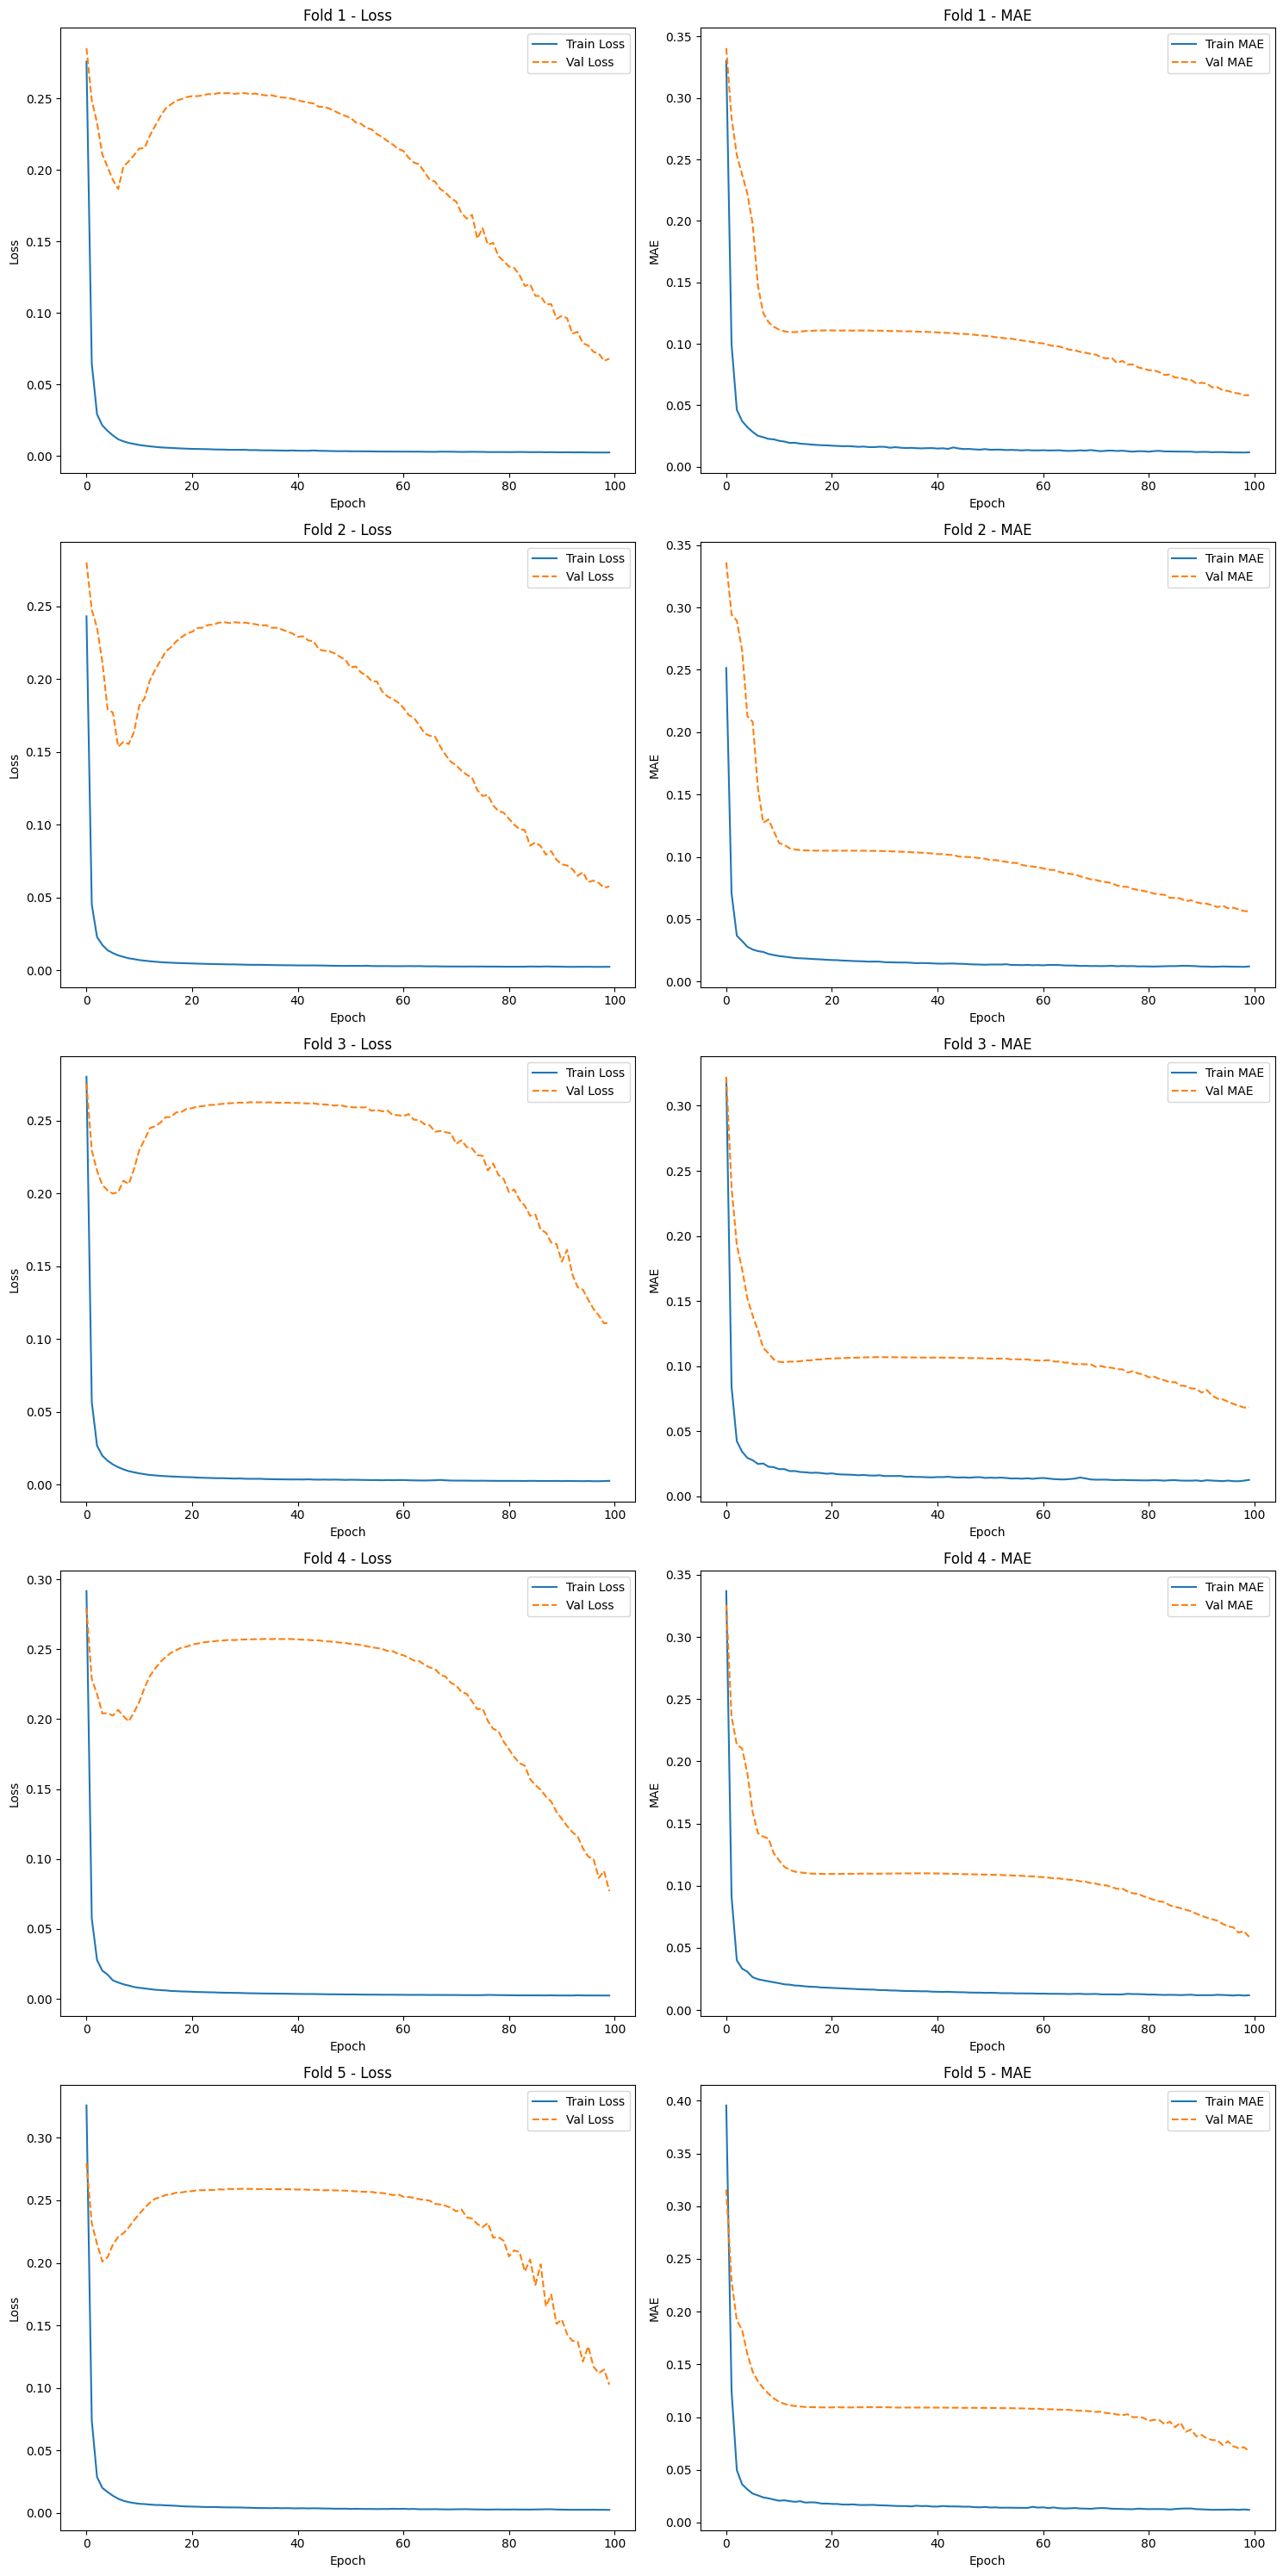

In [178]:
plot_individual_folds(histories) 

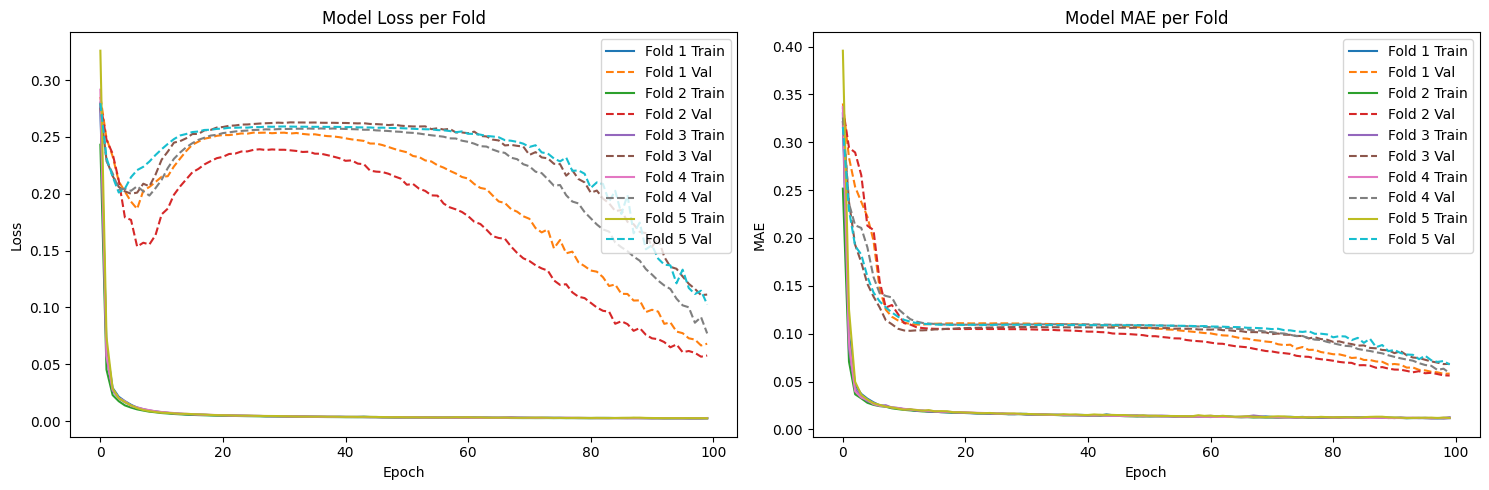

In [179]:
plot_comparative_folds(histories)

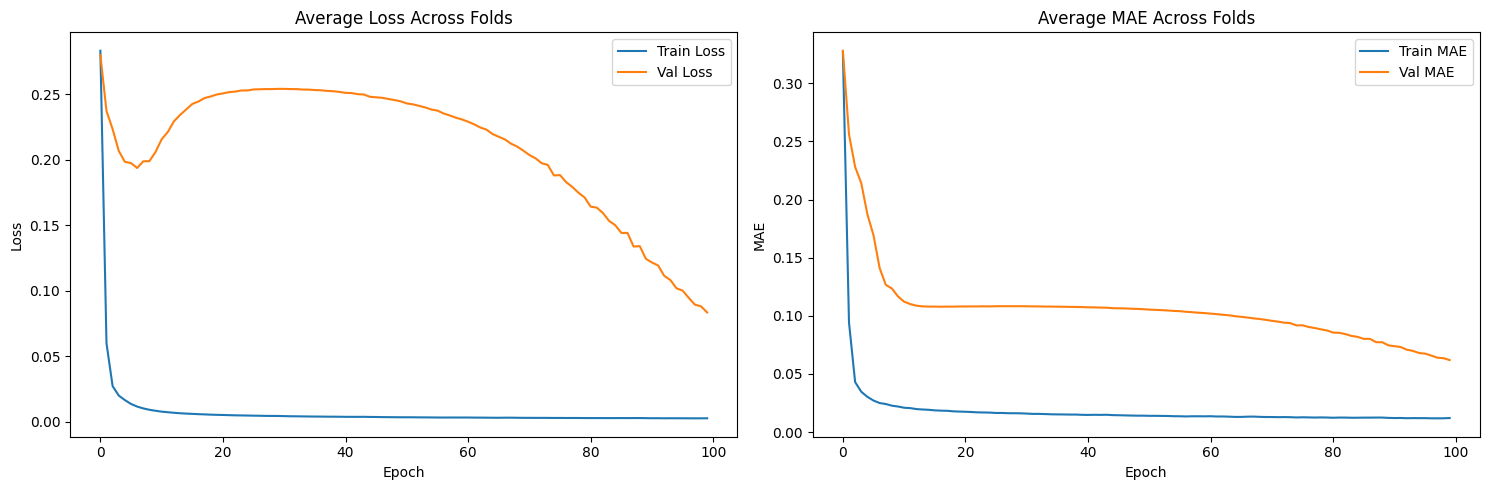

In [180]:
plot_average_metrics(histories)

In [181]:
print("\nTraining final model on the full dataset...")
train_generator, num_train_samples = prepare_data(batch_size=32)
final_model = build_model()

history = final_model.fit(train_generator, epochs=300, verbose=1)
final_model.save('final_model.keras')


Training final model on the full dataset...
Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.3190 - mae: 0.3618
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0527 - mae: 0.0783
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0248 - mae: 0.0413
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0189 - mae: 0.0327
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0155 - mae: 0.0305
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0124 - mae: 0.0273
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0105 - mae: 0.0249
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0090 - mae: 0.0240
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0081 - mae: 0.0231
Epoch 10/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0072 - mae: 0.0213
Epoch 11/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.0068 - mae: 0.0205
Epoch 12/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.0063 - mae: 0

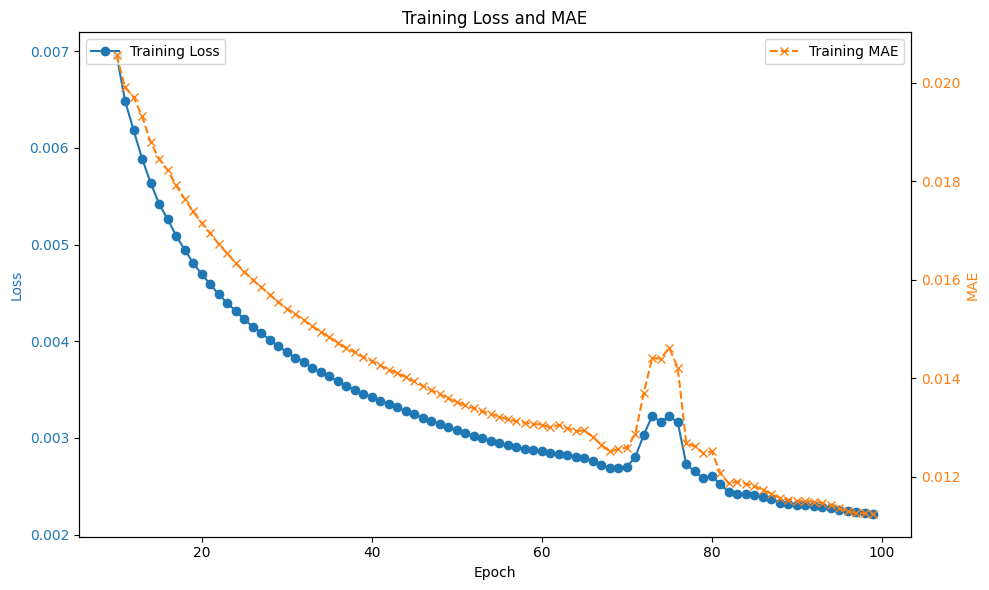

In [182]:
plot_training_history(history, epoch_start=10, epoch_end=100)

In [183]:
print("\nGenerating predictions...")
predictions = []
test_paths = sorted([os.path.join(path, 'test', f) for f in os.listdir(os.path.join(path, 'test'))])
test_generator = data_generator_tf(test_paths, batch_size=32)

for batch in test_generator:
    if isinstance(batch, tuple):
        batch = batch[0]
    
    pred_batch = final_model.predict(batch, verbose=0)
    predictions.extend(pred_batch)

Y_test = np.array(predictions)

print(f"Predictions shape: {Y_test.shape}")


Generating predictions...
Predictions shape: (72, 270, 350, 1)


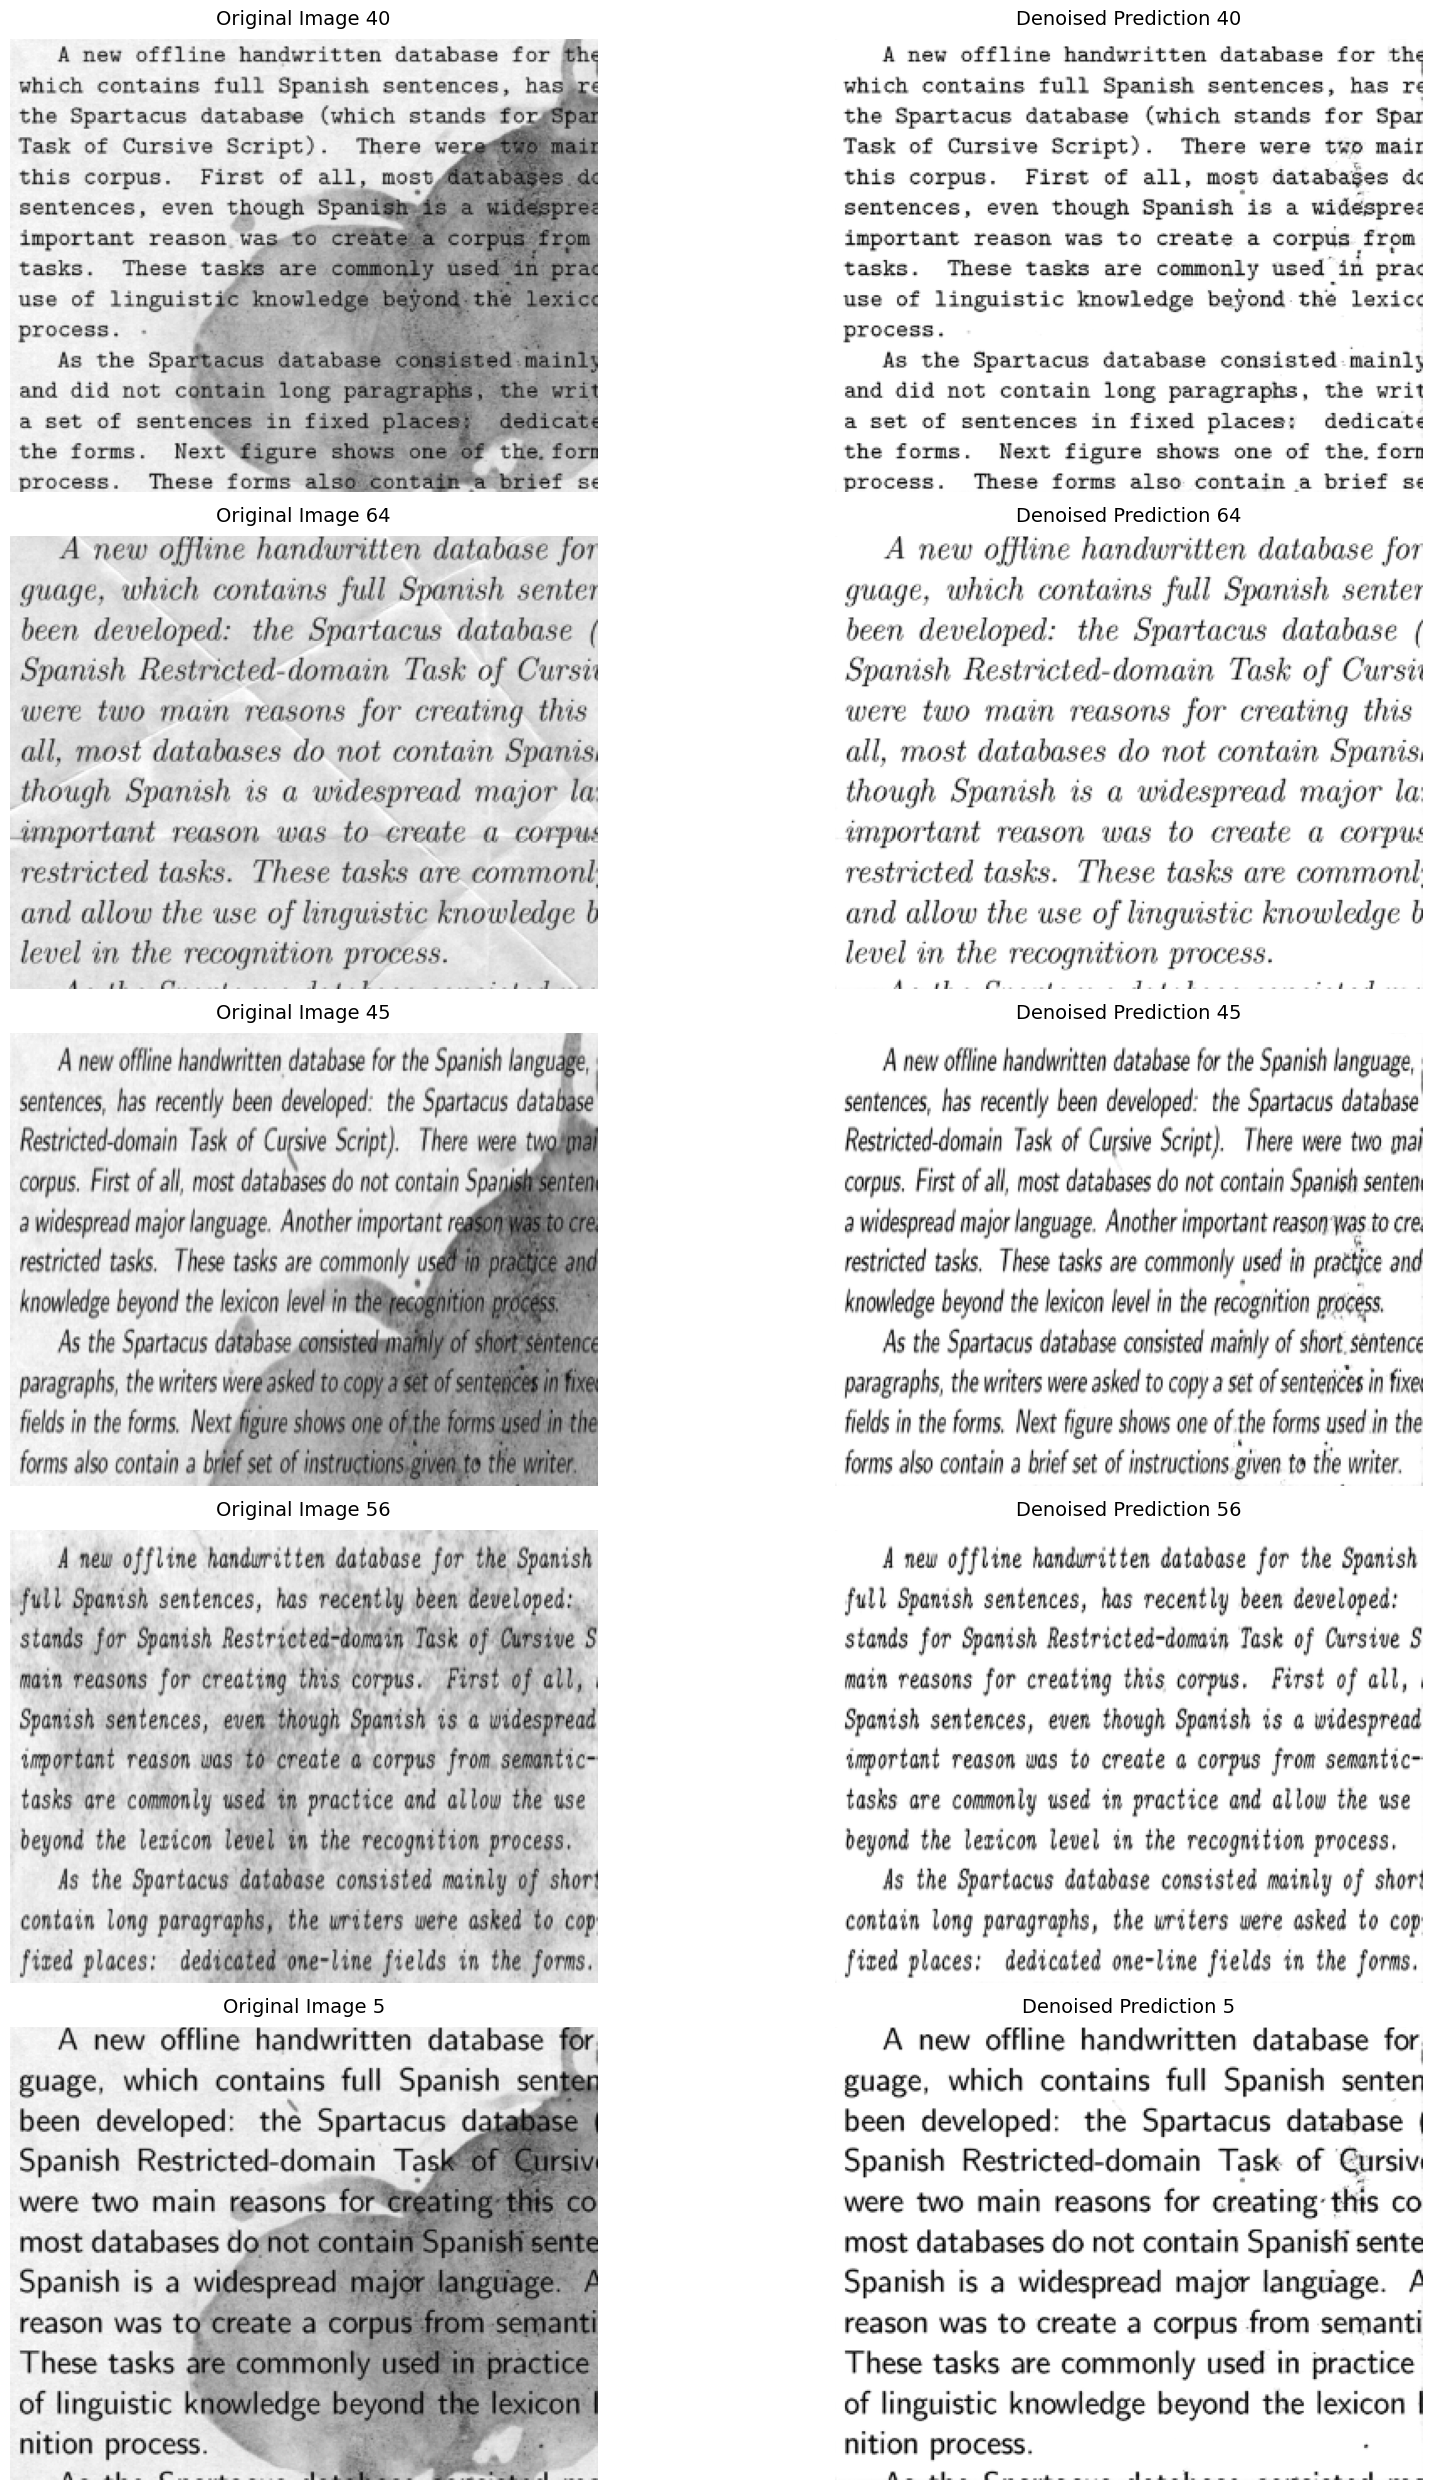

In [184]:
import matplotlib.pyplot as plt
import numpy as np
import random

test_paths = sorted([os.path.join(path, 'test', f) for f in os.listdir(os.path.join(path, 'test'))])
random_indices = random.sample(range(len(test_paths)), 5)

plt.figure(figsize=(20, 25))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

for idx, i in enumerate(random_indices):
    test_img = process_image_tensor(test_paths[i]).numpy()
    pred_img = Y_test[i]
    
    plt.subplot(5, 2, 2*idx + 1)
    plt.imshow(test_img.squeeze(), cmap='gray')
    plt.title(f'Original Image {i}', pad=10, fontsize=14)
    plt.axis('off')
    
    plt.subplot(5, 2, 2*idx + 2)
    plt.imshow(pred_img.squeeze(), cmap='gray')
    plt.title(f'Denoised Prediction {i}', pad=10, fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

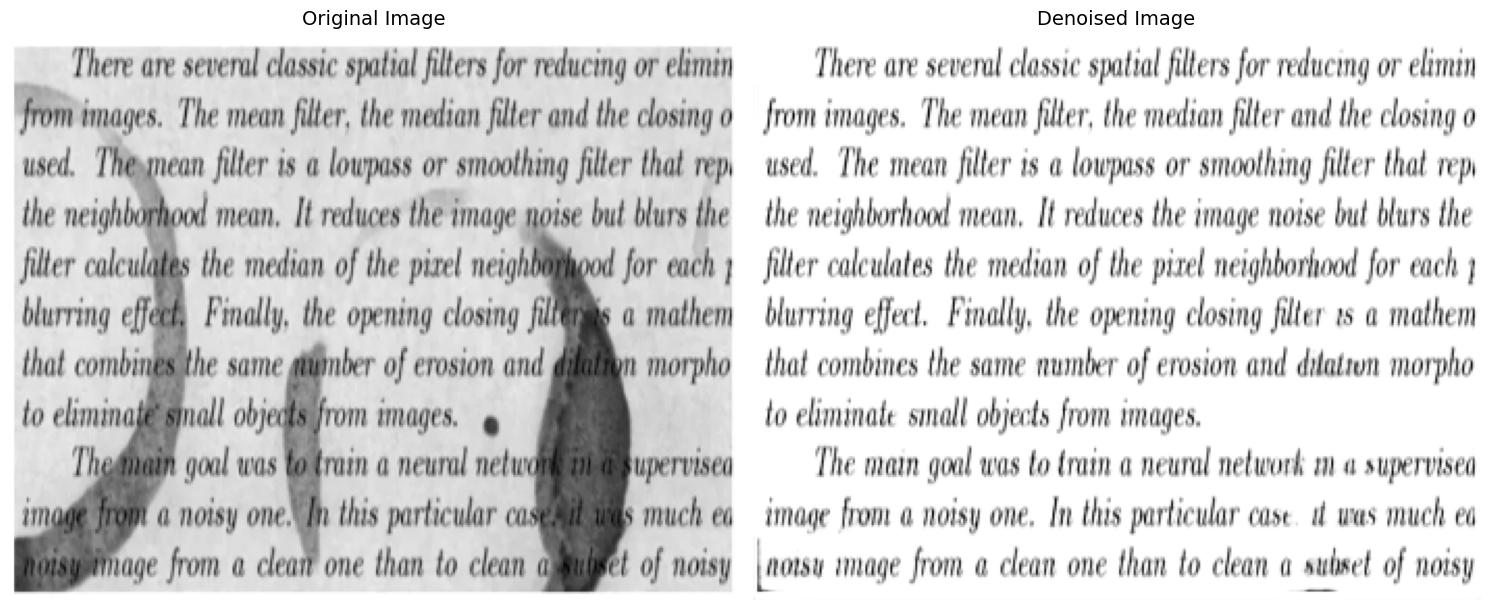

In [185]:
from tensorflow.keras.models import load_model

final_model = load_model('final_model.keras', custom_objects={'custom_loss': custom_loss})

def denoise_image(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    img = img / 255.0
    img = cv2.resize(img, (350, 270))
    
    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, -1)  
    img = tf.expand_dims(img, 0)   
    
    prediction = model.predict(img, verbose=0)[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    ax1.imshow(tf.squeeze(img[0]), cmap='gray')
    ax1.set_title('Original Image', fontsize=14, pad=10)
    ax1.axis('off')
    
    ax2.imshow(tf.squeeze(prediction), cmap='gray')
    ax2.set_title('Denoised Image', fontsize=14, pad=10)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

denoise_image('/kaggle/input/just-testing/dl_1.png', final_model)

In [186]:
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time:.2f} seconds")

Total time taken: 1097.52 seconds
